In [658]:
import requests, json
from bs4 import BeautifulSoup   
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype


In [659]:
RANDOM_SEED = 42

In [660]:
test_cars=pd.read_csv('test_cars.csv')
test_cars=test_cars.drop(['car_url', 'complectation_dict', 'image', 'model_info', 
                          'parsing_unixtime', 'priceCurrency', 'sell_id', 'super_gen', 'vendor', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38'], axis=1)
data_par = pd.read_csv('all_auto_ru_07_12_2020-11.csv')

data_par=data_par.drop([ 'start_date', 'hidden'], axis=1)
test_cars['sample']=1
data_par['sample']=0

data = test_cars.append(data_par, sort=False).reset_index(drop=True)
data.columns =  ['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'name', 'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession', 'PTS', 'drive_unit', 'rudder',
       'state', 'choky', 'sample', 'equipment_dict2', 'price']
data

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,...,owners,Possession,PTS,drive_unit,rudder,state,choky,sample,equipment_dict2,price
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013,...,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227014,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,NaN,ORIGINAL,передний,LEFT,NaN,True,0,{'id': '0'},45000.0
227015,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,NaN,ORIGINAL,передний,LEFT,NaN,True,0,{'id': '0'},45000.0
227016,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,NaN,ORIGINAL,передний,LEFT,NaN,True,0,{'id': '0'},45000.0
227017,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,NaN,ORIGINAL,передний,LEFT,NaN,True,0,{'id': '0'},45000.0


# Тут мы парсим сайт

# Проверим датасет на наличие пропусков:

In [661]:
data.isnull().sum()

bodyType                     0
brand                        0
color                        0
description               7212
engineDisplacement          10
enginePower                 10
equipment_dict            9992
fuelType                     3
mileage                      0
modelDate                    0
model_name                   0
name                        11
numberOfDoors                0
productionDate               0
vehicleConfiguration        10
vehicleTransmission         10
owners                      30
Possession              155240
PTS                         35
drive_unit                  10
rudder                       0
state                   192333
choky                        0
sample                       0
equipment_dict2          34686
price                    34690
dtype: int64

Заполним наны наиболее распостраненным значением или введём значение 'unknown' для случаев где очень много данных отсутствуют

In [662]:
nul_col=['engineDisplacement', 'enginePower', 'fuelType', 'name', 'vehicleConfiguration', 'vehicleTransmission', 'drive_unit', 'PTS', "owners" ]
for col in data[nul_col]:
    ch=data[col].value_counts().index[0]
    data[col]=data[col].fillna(ch)
unkn_col=['description', 'Possession', 'state']
for col in data[unkn_col]:
    data[col]=data[col].fillna('unknown')
    

In [663]:
data.isnull().sum()

bodyType                    0
brand                       0
color                       0
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9992
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
owners                      0
Possession                  0
PTS                         0
drive_unit                  0
rudder                      0
state                       0
choky                       0
sample                      0
equipment_dict2         34686
price                   34690
dtype: int64

В некоторых столбцах часто попадаются некорректно внесённые значения. Они, как правило не повторяются, поэтому можем отфильтровать их

In [664]:
columns_to_clean=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession',
       'PTS', 'drive_unit', 'rudder',  'choky' ]
for col in columns_to_clean:
    data = data[data[col].isin(data[col].value_counts()[data[col].value_counts()>5].index)]

data

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,...,owners,Possession,PTS,drive_unit,rudder,state,choky,sample,equipment_dict2,price
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013,...,3 или более,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017,...,1 владелец,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013,...,1 владелец,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013,...,1 владелец,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008,...,1 владелец,unknown,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227014,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,unknown,ORIGINAL,передний,LEFT,unknown,True,0,{'id': '0'},45000.0
227015,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,unknown,ORIGINAL,передний,LEFT,unknown,True,0,{'id': '0'},45000.0
227016,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,unknown,ORIGINAL,передний,LEFT,unknown,True,0,{'id': '0'},45000.0
227017,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131,{},бензин,200000,1981,...,3,unknown,ORIGINAL,передний,LEFT,unknown,True,0,{'id': '0'},45000.0


# Обработаем числовые признаки

Столбцы "enginePower" , 'name', 'engineDisplacement', 'owners' помимо нужных нам числовых знвчений содержат ненужные текстовые. Начнём с чистки этих столбцов.

In [665]:
def splitting(s):
    return str(s).split(" ")[0]
data["enginePower"]=data["enginePower"].map(lambda s: splitting(s))
data['name']=data['name'].map(lambda s: splitting(s))
data['engineDisplacement'] = data['engineDisplacement'].map(lambda s: splitting(s))
data['owners'] = data['owners'].map(lambda s: splitting(s))
#data['owners'].apply(splitting)

Некоторые признаки хоть и выглядят как числовые имеют тип стринг. Выполним преобразование. 

In [666]:
def convert_to_int(col):
    def reg_clien(stringa):
        stringa=str(stringa).strip()
        try:
            res=re.findall('\d+\.?\d+', string=str(stringa))[0]
        except: 
            res = '0'
        return res
    
    data[col] = data[col].fillna('0')
    data[col] = data[col].map(lambda a: reg_clien(a))
    data[col] = data[col].astype(np.float64)
    #data[col].astype(np.int32, inplace=True)
        


for col in ['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners' ]:
    convert_to_int(col)




In [667]:
def doors(row):
    try:
        return int(row['numberOfDoors'].strip())
    except:
        return 5
data['numberOfDoors']=data.apply(lambda row:  doors(row), axis=1 )

Убедимся, что преобразование сработало:

In [668]:
for col in ['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors' ]:
    print(data[col].dtypes)

float64
float64
float64
float64
float64
float64
float64
int64


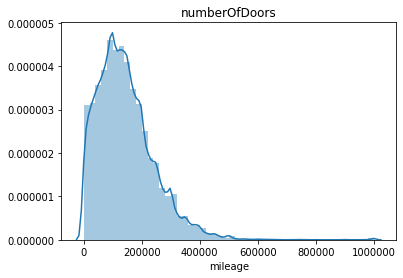

In [669]:
plt.figure()
sns.distplot(data['mileage'])
plt.title(col)
plt.show()
    

In [650]:
data['numberOfDoors'].value_counts()

5    211889
4     13339
2      1172
3       618
0         1
Name: numberOfDoors, dtype: int64

# Стандартизируем числовые признаки:

In [516]:
X_num = data[['engineDisplacement','enginePower', 'modelDate', 'name', 'mileage',  'productionDate', 'numberOfDoors']]
X_num = StandardScaler().fit_transform(X_num.values)

In [488]:
X_num

array([[-0.0678576 , -0.69341616,  0.73166038, ..., -0.7092094 ,
         0.64159962,  0.73724177],
       [-0.06783384, -0.64589521,  1.09632314, ..., -0.84477024,
         0.95397992,  0.73724177],
       [-0.06782195, -0.24671921,  0.73166038, ..., -0.56796867,
         0.64159962,  0.73724177],
       ...,
       [-0.06777442, -0.44630721, -2.18564168, ...,  0.56195719,
        -2.5863301 , -0.47670579],
       [-0.06777442, -0.44630721, -2.18564168, ...,  0.56195719,
        -2.5863301 , -0.47670579],
       [-0.06777442, -0.44630721, -2.18564168, ...,  0.56195719,
        -2.5863301 , -0.47670579]])

# Бинарные признаки

Столбцы 'drive_unit','rudder','state', 'choky' относятся к бинарным.
Над столбцом 'PTS' нужно произвести некоторые преобразования:
    

In [670]:
data['PTS'].value_counts()

ORIGINAL     168105
Оригинал      29462
DUPLICATE     24188
Дубликат       4474
Name: PTS, dtype: int64

In [671]:
data['PTS'] = data['PTS'].str.replace('Оригинал', 'ORIGINAL')
data['PTS'] = data['PTS'].str.replace('Дубликат', 'DUPLICATE')
data['PTS'].value_counts()

ORIGINAL     197567
DUPLICATE     28662
Name: PTS, dtype: int64

In [ ]:
data['rudder'] = data['rudder'].str.replace('Левый', 'LEFT')
data['rudder'] = data['rudder'].str.replace('Правый', 'RIGHT')

In [672]:
data['choky']=data['choky'].astype('str')

In [673]:
X_bin = data[['drive_unit','rudder','state',  'PTS','choky']]
#bin_cols = ['drive_unit','rudder','state',  'PTS','choky']


In [674]:
label_encoder = LabelEncoder()

for column in X_bin.columns:
    X_bin[column] = label_encoder.fit_transform(X_bin[column])
X_bin.head(3)

C:\Users\trigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,drive_unit,rudder,state,PTS,choky
0,1,2,1,1,1
1,1,2,1,1,1
2,1,2,1,1,1
3,1,2,1,1,1
4,1,2,1,1,1
...,...,...,...,...,...
227014,1,0,0,1,0
227015,1,0,0,1,0
227016,1,0,0,1,0
227017,1,0,0,1,0


# Категориальные и бинарные признаки

In [524]:
data['fuelType'].value_counts()

бензин         191883
дизель          31953
гибрид           1542
электро           794
газ                47
внедорожник        10
Name: fuelType, dtype: int64

In [439]:
#data['Possession'].value_counts()

unknown                        154870
{'year': 2020, 'month': 1}       1014
{'year': 2018, 'month': 11}       875
{'year': 2018, 'month': 9}        846
{'year': 2018, 'month': 10}       844
                                ...  
15 лет и 2 месяца                   6
15 лет и 3 месяца                   6
14 лет и 11 месяцев                 6
14 лет и 10 месяцев                 6
14 лет и 7 месяцев                  6
Name: Possession, Length: 508, dtype: int64

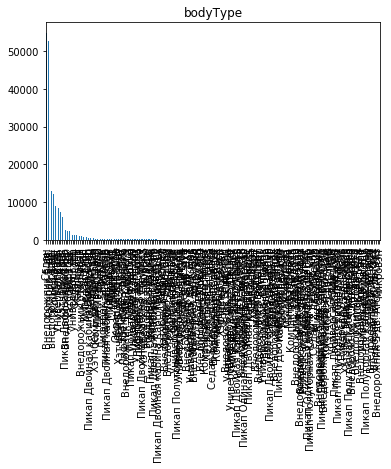

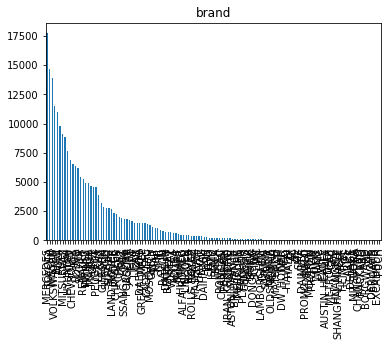

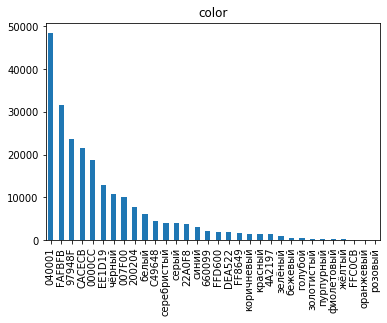

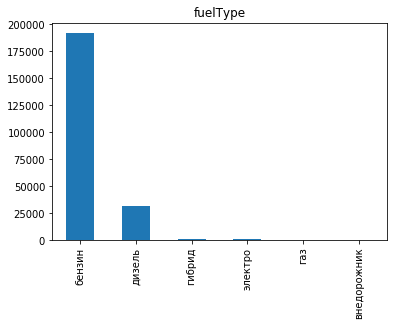

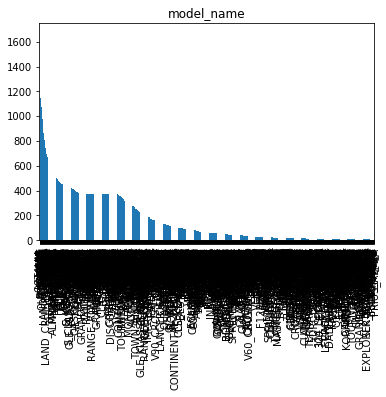

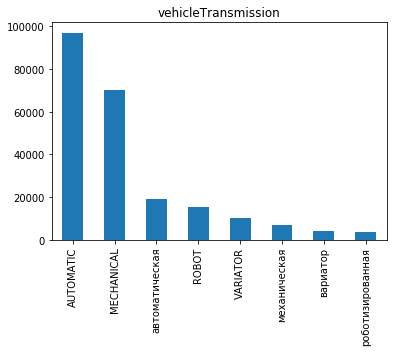

In [525]:
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    col_to_show=data[col].value_counts()
    col_to_show.plot(kind='bar', title=col)
    #sns.countplot(x=data[column], data=data[bin_cols])
    plt.show()

In [526]:
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    print('________________________')
    print(col)
    print('________________________')
    print(data[col].value_counts())

________________________
bodyType
________________________
Седан                              54909
Внедорожник 5 дв.                  52676
Хэтчбек 5 дв.                      21507
седан                              12929
внедорожник 5 дв.                  12122
                                   ...  
Внедорожник 5 дв. XUV                 10
Седан Japan Market                    10
Внедорожник 5 дв. 4x4                  9
Внедорожник 5 дв. Arctic Trucks        9
микровэн                               5
Name: bodyType, Length: 191, dtype: int64
________________________
brand
________________________
MERCEDES      17719
TOYOTA        14670
NISSAN        13919
VOLKSWAGEN    11521
BMW           10996
              ...  
ZIS              10
DERWAYS          10
BUGATTI          10
EXCALIBUR        10
PUCH             10
Name: brand, Length: 130, dtype: int64
________________________
color
________________________
040001         48414
FAFBFB         31663
97948F         23725
CACECB        

In [ ]:
Признаки, имеющие не очень большое количество разных значений кодируем OneHotEncoder

In [ ]:
X_cat_01=[['fuelType', 'vehicleTransmission']]

In [676]:
X_cat_01= OneHotEncoder(sparse = False).fit_transform(X_cat_01)
X_cat_01

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.]])

In [600]:
X_cat_02 = data[['brand','bodyType','color','model_name']]
vc_brands = data['brand'].value_counts()
vc_body = data['bodyType'].value_counts()
vc_color = data['color'].value_counts()
vc_model =  data['model_name'].value_counts()

def encoder_br(row):
    br=row['brand']
    return vc_brands[br]

def encoder_body(row):
    bo=row['bodyType']
    return vc_body[bo]

def encoder_color(row):
    co=row['color']
    return vc_color[co]

def encoder_model(row):
    mo=row['model_name']
    return vc_model[mo]


    
X_cat_02['brand']=data.apply(lambda row: encoder_br(row), axis=1)
X_cat_02['bodyType']=data.apply(lambda row: encoder_body(row), axis=1)
X_cat_02['color']=data.apply(lambda row: encoder_color(row), axis=1)
X_cat_02['model_name']=data.apply(lambda row: encoder_model(row), axis=1)





C:\Users\trigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\trigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\trigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [601]:
X_cat_02

,brand,bodyType,color,model_name
0,5471,2232,3289,1676
1,5471,2232,11010,1676
2,5471,2232,3984,618
3,5471,2232,1501,1676
4,5471,2232,6133,1676
...,...,...,...,...
227014,2338,54920,31664,10
227015,2338,54920,31664,10
227016,2338,54920,31664,10
227017,2338,54920,31664,10


In [537]:
X_cat_02 = data[['brand','bodyType','color','model_name']]

In [596]:

vc_brands = data['brand'].value_counts()
vc_body = data['bodyType'].value_counts()
vc_color = data['color'].value_counts()
vc_model =  data['model_name'].value_counts()

def encoder(row, cols):
    
    for col in cols:
        
        vc=data[col].value_counts()
        a=row[col]
        return vc[a]
    #br=row['brand']
    #print(br, vc_brands[br] )
    
    #return vc_brands[br]
    
data['brand2']=data.apply(lambda row: encoder(row, X_cat_02.columns), axis=1)

KeyboardInterrupt: 

In [593]:
data['brand2'].value_counts()

17881    17881
14820    14820
13980    13980
11585    11585
11103    11103
         ...  
40         120
60         120
111        111
100        100
70          70
Name: brand2, Length: 81, dtype: int64

In [570]:
X_cat_02

,brand,bodyType,color,model_name
0,None,лифтбек,синий,OCTAVIA
1,None,лифтбек,чёрный,OCTAVIA
2,None,лифтбек,серый,SUPERB
3,None,лифтбек,коричневый,OCTAVIA
4,None,лифтбек,белый,OCTAVIA
...,...,...,...,...
227014,None,Седан,FAFBFB,ARIES
227015,None,Седан,FAFBFB,ARIES
227016,None,Седан,FAFBFB,ARIES
227017,None,Седан,FAFBFB,ARIES


In [556]:
vc.index

Index(['OCTAVIA', '5ER', 'LANCER', 'E_KLASSE', 'PASSAT', 'A6', '3ER', 'POLO',
       'CAMRY', 'X5',
       ...
       'U7_TURBO', 'TRANS_SPORT', 'SLR_KLASSE', 'MIRA_E_S', '203', 'NOVA',
       'TRAVERSE', 'FARGO', '326', 'PRIUS_ALPHA'],
      dtype='object', length=1361)

In [549]:
for col in data[['brand','bodyType','color','model_name']]:
    vc=data[col].value_counts()
    print(vc)

MERCEDES      17719
TOYOTA        14670
NISSAN        13919
VOLKSWAGEN    11521
BMW           10996
              ...  
ZIS              10
DERWAYS          10
BUGATTI          10
EXCALIBUR        10
PUCH             10
Name: brand, Length: 130, dtype: int64
Седан                              54909
Внедорожник 5 дв.                  52676
Хэтчбек 5 дв.                      21507
седан                              12929
внедорожник 5 дв.                  12122
                                   ...  
Внедорожник 5 дв. XUV                 10
Седан Japan Market                    10
Внедорожник 5 дв. 4x4                  9
Внедорожник 5 дв. Arctic Trucks        9
микровэн                               5
Name: bodyType, Length: 191, dtype: int64
040001         48414
FAFBFB         31663
97948F         23725
CACECB         21550
0000CC         18753
EE1D19         12861
чёрный         10809
007F00         10166
200204          7707
белый           6035
C49648          4424
серебристый     4

In [557]:
data.groupby(['brand']).count()

,bodyType,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,...,owners,Possession,PTS,drive_unit,rudder,state,choky,sample,equipment_dict2,price
brand,,,,,,,,,,,,,,,,,,,,,
AC,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
ACURA,620,620,620,620,620,620,620,620,620,620,...,620,620,620,620,620,620,620,620,620,620
ALFA_ROMEO,490,490,490,490,490,490,490,490,490,490,...,490,490,490,490,490,490,490,490,490,490
ALPINA,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
AMC,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZAZ,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,...,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
ZIL,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
ZIS,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


# Превратим длинные строковые значения в столбце 'equipment_dict' в списки.

In [562]:
def dict_1(row):
    try:
        res= list(json.loads(row['equipment_dict']).keys())
    except:
        res=[]
    
    return res
data['equipment_dict']=data.apply(lambda row: dict_1(row), axis=1)

In [563]:
data['equipment_dict']

0         [engine-proof, tinted-glass, airbag-driver, au...
1         [cruise-control, asr, esp, airbag-driver, isof...
2         [cruise-control, tinted-glass, esp, adaptive-l...
3         [cruise-control, roller-blind-for-rear-window,...
4         [cruise-control, asr, esp, airbag-driver, isof...
                                ...                        
227014                                                   []
227015                                                   []
227016                                                   []
227017                                                   []
227018                                                   []
Name: equipment_dict, Length: 226229, dtype: object

Из столбца 'equipment_dict2' выгрузим значения 'available_options' в json

In [564]:
def dict_2(row):
    try:
        res= json.loads(row['equipment_dict2'].replace("'", '"'))['available_options']
    except:
        res=[]
    
    return res
data['equipment_dict2']=data.apply(lambda row: dict_2(row), axis=1)

Теперь в столбцах 'equipment_dict' и 'equipment_dict2'расположениы списки укомплектации для каждой машины. Посмотрим какие элементы комплектации встречаются чаще всего, чтоб создать отдельные признаки опираясь на наличие этих элементов

In [565]:
equip=[]
for car in data['equipment_dict']:
    try:
        for eq in car:
            equip.append(eq)
 
    except:
        continue
equipment=pd.Series(equip)
equipment=equipment.value_counts()
equipment=equipment[equipment.values>10000]
equipment

lock                    20797
abs                     20445
electro-mirrors         18495
airbag-driver           17394
computer                17269
electro-window-front    17155
front-seats-heat        17103
airbag-passenger        16943
ptf                     15905
immo                    15717
electro-window-back     15040
airbag-side             14490
aux                     14238
wheel-power             14090
esp                     13954
mirrors-heat            13749
wheel-leather           13361
multi-wheel             12868
usb                     12742
front-centre-armrest    12623
rain-sensor             12422
wheel-configuration1    12369
light-sensor            12219
bluetooth               11723
cruise-control          11695
light-cleaner           11617
12v-socket              11560
tinted-glass            11454
leather                 10590
alloy-wheel-disks       10209
park-assist-r           10095
wheel-configuration2    10080
dtype: int64

In [566]:
for col in equipment.index:
    def eq_col(row):
        return int((col in row['equipment_dict']) or (col in row['equipment_dict2']) )
    
    data[col]=data.apply(lambda row: eq_col(row), axis=1)

In [567]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,...,light-sensor,bluetooth,cruise-control,light-cleaner,12v-socket,tinted-glass,leather,alloy-wheel-disks,park-assist-r,wheel-configuration2
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2,105.0,"[engine-proof, tinted-glass, airbag-driver, au...",бензин,74000.0,2013.0,...,0,0,0,0,1,1,0,0,1,1
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110.0,"[cruise-control, asr, esp, airbag-driver, isof...",бензин,60563.0,2017.0,...,1,1,1,0,0,0,0,1,1,1
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8,152.0,"[cruise-control, tinted-glass, esp, adaptive-l...",бензин,88000.0,2013.0,...,1,0,1,1,1,1,0,1,1,1
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6,110.0,"[cruise-control, roller-blind-for-rear-window,...",бензин,95000.0,2013.0,...,1,1,1,1,1,1,0,1,1,1
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8,152.0,"[cruise-control, asr, esp, airbag-driver, isof...",бензин,58536.0,2008.0,...,1,0,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227014,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131.0,[],бензин,200000.0,1981.0,...,0,0,0,0,0,0,0,0,0,0
227015,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131.0,[],бензин,200000.0,1981.0,...,0,0,0,0,0,0,0,0,0,0
227016,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131.0,[],бензин,200000.0,1981.0,...,0,0,0,0,0,0,0,0,0,0
227017,Седан,DODGE,FAFBFB,Doge Aries с документами сеят с учета на транз...,2.6,131.0,[],бензин,200000.0,1981.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [ ]:
# Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values